# 토크나이저 구축

**목표**: 데이터 로드 → 토크나이저 학습 → 데이터 로더 생성

## 1. 라이브러리 import

In [43]:
# koreanize-matplotlib 라이브러리 설치
%pip install koreanize-matplotlib -q

# matplotlib 라이브러리, matplotlib에서 한글을 사용하기 위한 라이브러리 임포트
import matplotlib.pyplot as plt
import koreanize_matplotlib

import os
import pickle
from collections import Counter

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import numpy as np
from datasets import load_dataset

# ---- 환경 정보 출력 ----
device = "cuda" if torch.cuda.is_available() else "cpu"

print("=" * 60)
print("환경 정보")
print("=" * 60)
print(f"- PyTorch version   : {torch.__version__}")
print(f"- GPU available     : {torch.cuda.is_available()}")
print(f"- Device selected   : {device}")

Note: you may need to restart the kernel to use updated packages.
환경 정보
- PyTorch version   : 2.9.1
- GPU available     : False
- Device selected   : cpu


## 2. SpellGram 데이터 로드

### SpellGram 데이터 로드

In [44]:
print("=" * 60)
print("SpellGram 데이터셋 로드 & 분리")
print("=" * 60)

ds = load_dataset("vishnun/SpellGram")
full_data = ds["train"]

print(f"- 전체 데이터 개수: {len(full_data)}")
train_val_split = full_data.train_test_split(
    test_size=0.1,
    seed=42
)

train_data = train_val_split["train"]
test_data  = train_val_split["test"]

# Train/Val/Test 분리
print(f"- Train+Val: {len(train_data)}")
print(f"- Test     : {len(test_data)}")

SpellGram 데이터셋 로드 & 분리
- 전체 데이터 개수: 40000
- Train+Val: 36000
- Test     : 4000


## 3. 토크나이저 구축

#### Special Tokens 설명 (PAD, UNK, SOS, EOS)

- 자연어 처리(NLP) 모델을 학습할 때는 문장 자체뿐 아니라 모델이 이해할 수 있는 특수 토큰(Special Tokens)을 사용해야 함
- 모델이 문장의 구조를 인식하고, 입력 길이를 맞추고, 생성의 시작과 끝을 알 수 있도록 돕는 역할


#### &lt;PAD&gt; (Padding Token) : 빈 칸(패딩)을 채우기 위한 토큰</h4>
- 모델은 한 배치(batch) 안에서 모든 문장의 길이가 동일해야 텐서를 만들 수 있음
- 길이가 다르면 연산이 불가능하므로 짧은 문장들을 <PAD>로 채워 길이를 맞춰줌

```python
문장1: this is good
문장2: hi

패딩 후:
문장1: this is good
문장2: hi <PAD> <PAD>

```

- LSTM, Transformer 등 대부분의 모델에서 필수
- 보통 index 0으로 설정함 (연산적으로 유리)


&lt;UNK&gt; (Unknown Token) : 어휘집(vocab)에 없는 단어를 대신하는 토큰
- 학습 중이거나 예측 단계에서 새로운 단어(OOV: Out-of-vocabulary)가 등장할 수 있음
- 이때 해당 단어를 &lt;UNK&gt;로 치환해 처리

```python
“I love k-pop”
k-pop → vocab에 없음 → <UNK>

```

#### &lt;SOS&gt; (Start Of Sentence) : 문장의 시작을 나타내는 토큰
- RNN/LSTM 기반 seq2seq 모델(번역기, 오타교정기 등)의 Decoder는 “어디서부터 생성해야 하는지”를 알아야 함

```python
Decoder 입력 예
<SOS> i love machine learning <EOS>

```

&lt;SOS&gt;는 생성 시작 신호

#### &lt;EOS&gt; (End Of Sentence) : 문장의 끝을 의미하는 토큰
- 생성 모델이 언제 문장을 끝내야 할지를 알려줌.
- &lt;EOS&gt;가 없으면 모델이 계속 단어를 생성해서 무한루프에 빠질 수도 있음.


```python
i → love → cats → <EOS>
```

<EOS> 등장 시 생성 종료

In [45]:
# ===================================
#     토크나이저 & 어휘집 생성 클래스
# ===================================
from collections import Counter

class SimpleTokenizer:
    """
    간단한 단어 기반 토크나이저 + 어휘집(Vocabulary) 관리 클래스
    PAD, UNK, SOS, EOS 4개 기본 토큰 포함
    """
    
    def __init__(self, vocab_size=10000):
        self.vocab_size = vocab_size
        
        # 기본 토큰 정의
        self.word2idx = {
            '<PAD>': 0, # Padding Token, 배치 연산 위해 문장 길이 맞추기
            '<UNK>': 1, # Unknown Token, 어휘집에 없는 단어 처리
            '<SOS>': 2, # Start of Sentence, 문장 생성 시작 신호
            '<EOS>': 3  # End of Sentence, 문장 종료 신호
        }
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}
        
        self.word_freq = Counter()   # 단어 빈도
        print(f"[Init] 기본 vocab size: {len(self.word2idx)} / 목표 vocab: {vocab_size}")

    # ------------------------------
    #          어휘집 만들기
    # ------------------------------
    def build_vocab(self, texts):
        """
        전체 문장 리스트를 받아 단어 빈도 기반 어휘집 구축
        """
        print("[Vocab] 어휘집 생성 중...")

        # None 또는 빈 문자열 방지
        for text in texts:
            if text:
                self.word_freq.update(text.split())

        # 가장 빈도 높은 단어부터 vocab_size만큼 추가
        next_idx = len(self.word2idx)

        for word, _ in self.word_freq.most_common(self.vocab_size - next_idx):
            self.word2idx[word] = next_idx
            self.idx2word[next_idx] = word
            next_idx += 1

        print(f"[Vocab] 구축 완료! 총 vocab size = {len(self.word2idx)}")

    # ------------------------------
    #      텍스트 → 토큰 ID 인코딩
    # ------------------------------
    def encode(self, text):
        """
        문장을 단어 단위로 ID 시퀀스로 변환
        """
        words = text.split() if text else []
        ids = [self.word2idx['<SOS>']]

        for w in words:
            ids.append(self.word2idx.get(w, self.word2idx['<UNK>']))

        ids.append(self.word2idx['<EOS>'])
        return ids

    # ------------------------------
    #      토큰 ID → 텍스트 디코딩
    # ------------------------------
    def decode(self, ids):
        """
        토큰 ID 시퀀스를 다시 문장으로 변환
        """
        tokens = []
        for idx in ids:
            word = self.idx2word.get(idx, '<UNK>')
            if word not in ['<SOS>', '<EOS>', '<PAD>']:
                tokens.append(word)
        return " ".join(tokens)

    def get_vocab_size(self):
        return len(self.word2idx)


print("SimpleTokenizer 클래스 로딩 완료")

SimpleTokenizer 클래스 로딩 완료


In [46]:
# 토크나이저 인스턴스 생성
tokenizer = SimpleTokenizer(vocab_size=10000)

# Vocab 만들기 — source + target 모두 포함
texts = [ex["source"] for ex in train_data] + \
        [ex["target"] for ex in train_data]

tokenizer.build_vocab(texts)

[Init] 기본 vocab size: 4 / 목표 vocab: 10000
[Vocab] 어휘집 생성 중...
[Vocab] 구축 완료! 총 vocab size = 10000


In [47]:
# UNK 비율 체크
unk_count = 0
total_count = 0

for ex in train_data:
    ids = tokenizer.encode(ex["source"])
    unk_count += ids.count(tokenizer.word2idx['<UNK>'])
    total_count += len(ids)

print(f"UNK 비율: {unk_count/total_count:.4f} ({unk_count}/{total_count})")

UNK 비율: 0.1787 (75781/424164)


### 문장 길이 통계

In [48]:
lengths = [len(ex["source"].split()) for ex in train_data]

print("="*50)
print("문장 길이 통계")
print("="*50)

print(f"- Min     : {min(lengths)} 단어")
print(f"- Max     : {max(lengths)} 단어")
print(f"- Mean    : {np.mean(lengths):.2f} 단어")
print(f"- Median  : {np.median(lengths):.2f} 단어")

print("\n구간별 분포:")
for th in [5,10,20,30,40,50]:
    count = sum(1 for l in lengths if l <= th)
    print(f"  ≤ {th} 단어: {count/len(lengths)*100:.1f}%")

문장 길이 통계
- Min     : 1 단어
- Max     : 40 단어
- Mean    : 9.78 단어
- Median  : 10.00 단어

구간별 분포:
  ≤ 5 단어: 9.8%
  ≤ 10 단어: 56.9%
  ≤ 20 단어: 99.8%
  ≤ 30 단어: 100.0%
  ≤ 40 단어: 100.0%
  ≤ 50 단어: 100.0%


### 토크나이저 학습

In [49]:
# 토크나이저 학습
print("\n" + "=" * 60)
print("토크나이저 학습 중...")
print("=" * 60)

# Source와 Target을 모두 포함해서 어휘집 구축
all_texts = []
for ex in train_data:
    if ex['source'] is not None:
        all_texts.append(ex['source'])
    if ex['target'] is not None:
        all_texts.append(ex['target'])

tokenizer = SimpleTokenizer(vocab_size=10000)
tokenizer.build_vocab(all_texts)

print(f"\n어휘 크기: {tokenizer.get_vocab_size()}")


토크나이저 학습 중...
[Init] 기본 vocab size: 4 / 목표 vocab: 10000
[Vocab] 어휘집 생성 중...
[Vocab] 구축 완료! 총 vocab size = 10000

어휘 크기: 10000


### 토크나이저 테스트

In [50]:
# 토크나이저 테스트
print("\n" + "=" * 60)
print("토크나이저 테스트")
print("=" * 60)

test_text = "rate the silent upeaker four out oe six"
print(f"\n원본 텍스트: {test_text}")

encoded = tokenizer.encode(test_text)
print(f"인코딩: {encoded}")

decoded = tokenizer.decode(encoded)
print(f"디코딩: {decoded}")

# 어휘집 일부 확인
print(f"\n어휘집 샘플 (word → idx):")
sample_words = list(tokenizer.word2idx.items())[:20]
for word, idx in sample_words:
    print(f"  '{word}' → {idx}")


토크나이저 테스트

원본 텍스트: rate the silent upeaker four out oe six
인코딩: [2, 718, 4, 2218, 1, 141, 62, 891, 352, 3]
디코딩: rate the silent <UNK> four out oe six

어휘집 샘플 (word → idx):
  '<PAD>' → 0
  '<UNK>' → 1
  '<SOS>' → 2
  '<EOS>' → 3
  'the' → 4
  'a' → 5
  'of' → 6
  'in' → 7
  'and' → 8
  'is' → 9
  'to' → 10
  'was' → 11
  'on' → 12
  'he' → 13
  'it' → 14
  'are' → 15
  'with' → 16
  'for' → 17
  'i' → 18
  'his' → 19


## 4. 데이터 로더 구성

In [51]:
class SpellGramDataset(Dataset):
    """SpellGram 데이터셋 클래스"""
    
    def __init__(self, data, tokenizer, max_len=32):
        self.data = data
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        ex = self.data[idx]
        
        # 인코딩
        src_ids = self.tokenizer.encode(ex['source'])
        tgt_ids = self.tokenizer.encode(ex['target'])
        
        # 패딩 또는 자르기
        src_ids = src_ids[:self.max_len]
        tgt_ids = tgt_ids[:self.max_len]
        
        # 패딩
        src_ids = src_ids + [0] * (self.max_len - len(src_ids))
        tgt_ids = tgt_ids + [0] * (self.max_len - len(tgt_ids))
        
        return {
            'src': torch.tensor(src_ids, dtype=torch.long),
            'tgt': torch.tensor(tgt_ids, dtype=torch.long),
            'src_text': ex['source'],
            'tgt_text': ex['target']
        }

print("SpellGramDataset 클래스 정의 완료")

SpellGramDataset 클래스 정의 완료


### 데이터셋 생성

In [52]:
# 데이터셋 생성
print("\n" + "=" * 60)
print("데이터셋 생성")
print("=" * 60)

# 앞에서 train_test_split으로 train_data와 test_data를 만들었으므로 그것을 사용합니다
train_dataset = SpellGramDataset(train_data, tokenizer, max_len=32)
test_dataset = SpellGramDataset(test_data, tokenizer, max_len=32)

print(f"\nTrain dataset: {len(train_dataset)} examples")
print(f"Test dataset: {len(test_dataset)} examples")


데이터셋 생성

Train dataset: 36000 examples
Test dataset: 4000 examples


### 데이터 로더 생성

In [53]:
# 데이터 로더 생성
print("\n" + "=" * 60)
print("데이터 로더 생성")
print("=" * 60)

BATCH_SIZE = 32

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

print(f"\nTrain loader: {len(train_loader)} batches")
print(f"Test loader: {len(test_loader)} batches")


데이터 로더 생성

Train loader: 1125 batches
Test loader: 125 batches


In [54]:
# 배치 샘플 확인
print("\n" + "=" * 60)
print("배치 샘플 확인")
print("=" * 60)

batch = next(iter(train_loader))

print(f"\nBatch 크기:")
print(f"  - src shape: {batch['src'].shape}")
print(f"  - tgt shape: {batch['tgt'].shape}")

print(f"\n첫 번째 배치의 첫 3개 샘플:")
for i in range(min(3, len(batch['src']))):
    print(f"\n  [{i}]")
    print(f"      Source IDs: {batch['src'][i].tolist()[:10]}...")
    print(f"      Target IDs: {batch['tgt'][i].tolist()[:10]}...")
    print(f"      Source text: {batch['src_text'][i]}")
    print(f"      Target text: {batch['tgt_text'][i]}")


배치 샘플 확인

Batch 크기:
  - src shape: torch.Size([32, 32])
  - tgt shape: torch.Size([32, 32])

첫 번째 배치의 첫 3개 샘플:

  [0]
      Source IDs: [2, 4, 1, 1, 522, 206, 1, 1, 1, 1]...
      Target IDs: [2, 4, 1, 4506, 522, 206, 4506, 6673, 1, 3591]...
      Source text: the inorganic carboc species include carboc dsoxsde carbonic acqd bicarbonate anion and carbonate
      Target text: the inorganic carbon species include carbon dioxide carbonic acid bicarbonate anion and carbonate

  [1]
      Source IDs: [2, 1, 1131, 5564, 1, 3, 0, 0, 0, 0]...
      Target IDs: [2, 1, 7, 5564, 1511, 3, 0, 0, 0, 0]...
      Source text: chyyrlyadyrs jn maroon uniforws
      Target text: cheerleaders in maroon uniforms

  [2]
      Source IDs: [2, 4873, 32, 981, 1, 20, 7926, 3, 0, 0]...
      Target IDs: [2, 4873, 32, 981, 62, 20, 7926, 3, 0, 0]...
      Source text: repairs were carried eut at gibraltar
      Target text: repairs were carried out at gibraltar


### 1) UNK 비율 + vocab size 그래프 출력

→ vocab_size를 크게/작게 바꿨을 때 UNK 비율이 어떻게 변하는지 시각화

[Init] 기본 vocab size: 4 / 목표 vocab: 1000
[Vocab] 어휘집 생성 중...
[Vocab] 구축 완료! 총 vocab size = 1000
[Init] 기본 vocab size: 4 / 목표 vocab: 2000
[Vocab] 어휘집 생성 중...
[Vocab] 구축 완료! 총 vocab size = 2000
[Init] 기본 vocab size: 4 / 목표 vocab: 5000
[Vocab] 어휘집 생성 중...
[Vocab] 구축 완료! 총 vocab size = 5000
[Init] 기본 vocab size: 4 / 목표 vocab: 8000
[Vocab] 어휘집 생성 중...
[Vocab] 구축 완료! 총 vocab size = 8000
[Init] 기본 vocab size: 4 / 목표 vocab: 10000
[Vocab] 어휘집 생성 중...
[Vocab] 구축 완료! 총 vocab size = 10000
[Init] 기본 vocab size: 4 / 목표 vocab: 15000
[Vocab] 어휘집 생성 중...
[Vocab] 구축 완료! 총 vocab size = 15000


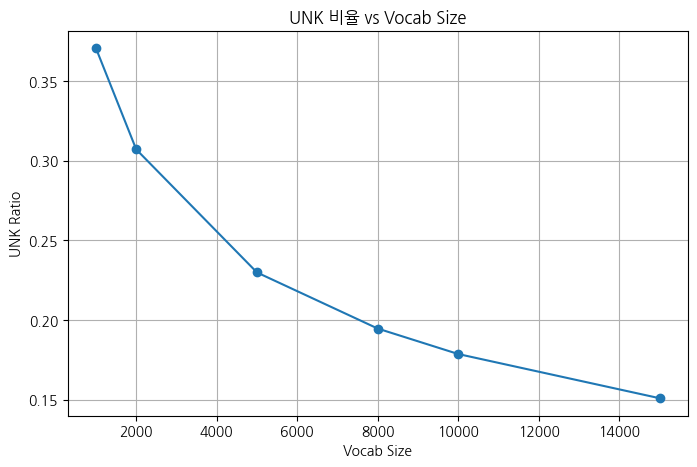

In [55]:
import matplotlib.pyplot as plt

def unk_ratio_for_vocab_size(vocab_sizes, train_data):
    ratios = []

    for vs in vocab_sizes:
        tok = SimpleTokenizer(vocab_size=vs)
        
        texts = [ex["source"] for ex in train_data] + \
                [ex["target"] for ex in train_data]
        tok.build_vocab(texts)

        unk = 0
        total = 0

        for ex in train_data:
            ids = tok.encode(ex["source"])
            unk += ids.count(tok.word2idx['<UNK>'])
            total += len(ids)

        ratios.append(unk / total)

    return ratios

vocab_sizes = [1000, 2000, 5000, 8000, 10000, 15000]
unk_ratios = unk_ratio_for_vocab_size(vocab_sizes, train_data)

plt.figure(figsize=(8, 5))
plt.plot(vocab_sizes, unk_ratios, marker='o')
plt.title("UNK 비율 vs Vocab Size")
plt.xlabel("Vocab Size")
plt.ylabel("UNK Ratio")
plt.grid(True)
plt.show()

### 2) source / target 각각 UNK 비율 비교

In [56]:
# source UNK 비율
src_unk = 0
src_total = 0

for ex in train_data:
    ids = tokenizer.encode(ex["source"])
    src_unk += ids.count(tokenizer.word2idx['<UNK>'])
    src_total += len(ids)

# target UNK 비율
tgt_unk = 0
tgt_total = 0

for ex in train_data:
    ids = tokenizer.encode(ex["target"])
    tgt_unk += ids.count(tokenizer.word2idx['<UNK>'])
    tgt_total += len(ids)

print("UNK 비율 비교")
print(f"- Source UNK: {src_unk/src_total:.4f}")
print(f"- Target UNK: {tgt_unk/tgt_total:.4f}")

UNK 비율 비교
- Source UNK: 0.1788
- Target UNK: 0.0820


### 3) vocab_size 최적 추천 코드
→ UNK 비율이 5% 미만이 되는 최소 vocab_size 추천

In [57]:
def recommend_vocab_size(vocab_sizes, train_data):
    for vs in sorted(vocab_sizes):
        tok = SimpleTokenizer(vocab_size=vs)
        texts = [ex["source"] for ex in train_data] + \
                [ex["target"] for ex in train_data]
        tok.build_vocab(texts)

        unk = 0
        total = 0
        for ex in train_data:
            ids = tok.encode(ex["source"])
            unk += ids.count(tok.word2idx['<UNK>'])
            total += len(ids)

        ratio = unk / total
        print(f"Vocab {vs:5} → UNK ratio {ratio:.4f}")

        if ratio < 0.05:
            print(f"\n➡ 추천 vocab_size = {vs} (UNK < 5%)")
            return vs

    print("\n⚠ 적절한 vocab_size를 찾지 못했음.")
    return None

candidate_sizes = [2000, 4000, 6000, 8000, 10000, 12000]
recommended = recommend_vocab_size(candidate_sizes, train_data)

[Init] 기본 vocab size: 4 / 목표 vocab: 2000
[Vocab] 어휘집 생성 중...
[Vocab] 구축 완료! 총 vocab size = 2000
Vocab  2000 → UNK ratio 0.3072
[Init] 기본 vocab size: 4 / 목표 vocab: 4000
[Vocab] 어휘집 생성 중...
[Vocab] 구축 완료! 총 vocab size = 4000
Vocab  4000 → UNK ratio 0.2474
[Init] 기본 vocab size: 4 / 목표 vocab: 6000
[Vocab] 어휘집 생성 중...
[Vocab] 구축 완료! 총 vocab size = 6000
Vocab  6000 → UNK ratio 0.2159
[Init] 기본 vocab size: 4 / 목표 vocab: 8000
[Vocab] 어휘집 생성 중...
[Vocab] 구축 완료! 총 vocab size = 8000
Vocab  8000 → UNK ratio 0.1946
[Init] 기본 vocab size: 4 / 목표 vocab: 10000
[Vocab] 어휘집 생성 중...
[Vocab] 구축 완료! 총 vocab size = 10000
Vocab 10000 → UNK ratio 0.1787
[Init] 기본 vocab size: 4 / 목표 vocab: 12000
[Vocab] 어휘집 생성 중...
[Vocab] 구축 완료! 총 vocab size = 12000
Vocab 12000 → UNK ratio 0.1663

⚠ 적절한 vocab_size를 찾지 못했음.


### 4) vocab 저장 / 로드 (pickle)

In [58]:
# 저장
with open("tokenizer_vocab.pkl", "wb") as f:
    pickle.dump(tokenizer.word2idx, f)
print("vocab 저장 완료!")

# 로드
with open("tokenizer_vocab.pkl", "rb") as f:
    loaded_vocab = pickle.load(f)

print("로드된 vocab 크기:", len(loaded_vocab))

vocab 저장 완료!
로드된 vocab 크기: 10000


###  5) Tokenizer 유효성 검증 셀
→ encode → decode 했을 때 같은 문장이 나오는지 테스트

In [59]:
# 랜덤 샘플 5개 테스트
print("="*60)
print("Tokenizer Encode/Decode 검증")
print("="*60)

for i in range(5):
    ex = train_data[i]["source"]
    encoded = tokenizer.encode(ex)
    decoded = tokenizer.decode(encoded)

    print(f"\n원문: {ex}")
    print(f"인코딩: {encoded}")
    print(f"디코딩: {decoded}")

    if ex != decoded:
        print("⚠ Decode 결과가 다름 (UNK 또는 토큰화 이슈)")
    else:
        print("✔ 정상 (encode → decode 일치)")

Tokenizer Encode/Decode 검증

원문: the safks emety
인코딩: [2, 4, 1, 1, 3]
디코딩: the <UNK> <UNK>
⚠ Decode 결과가 다름 (UNK 또는 토큰화 이슈)

원문: vhe order was reportedly disregarded and they came into port anyway
인코딩: [2, 595, 610, 11, 4012, 1, 8, 39, 330, 56, 1804, 4698, 3]
디코딩: vhe order was reportedly <UNK> and they came into port anyway
⚠ Decode 결과가 다름 (UNK 또는 토큰화 이슈)

원문: hatred ks as blind as love
인코딩: [2, 1, 1839, 22, 2930, 22, 511, 3]
디코딩: <UNK> ks as blind as love
⚠ Decode 결과가 다름 (UNK 또는 토큰화 이슈)

원문: the canton has only a losg bordir with the rebt of switzerland
인코딩: [2, 4, 5649, 33, 90, 5, 1, 1, 16, 4, 1, 6, 2561, 3]
디코딩: the canton has only a <UNK> <UNK> with the <UNK> of switzerland
⚠ Decode 결과가 다름 (UNK 또는 토큰화 이슈)

원문: the children s voices melded beautifully is song
인코딩: [2, 4, 118, 120, 3533, 1, 6574, 9, 307, 3]
디코딩: the children s voices <UNK> beautifully is song
⚠ Decode 결과가 다름 (UNK 또는 토큰화 이슈)


#### 추가 아이디어 
- UNK가 어디에 발생했는지 실제 단어까지 표시
- 시각화(막대 그래프, pie chart)
- Levenshtein 기반 OOV 단어 분석
- Vocab pruning(희귀 단어 제거)
- subword tokenizer(BPE/WordPiece) 전환

## 5. 저장 및 요약

In [60]:
# 토크나이저 저장
import pickle

os.makedirs('./checkpoints', exist_ok=True)

with open('./checkpoints/tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

print("토크나이저 저장 완료: ./checkpoints/tokenizer.pkl")

토크나이저 저장 완료: ./checkpoints/tokenizer.pkl


In [62]:
# 최종 요약
print("\n" + "=" * 60)
print("최종 요약")
print("=" * 60)

# src_lengths 계산 (또는 기존 lengths 변수 사용)
src_lengths = [len(ex["source"].split()) for ex in train_data]

summary = f"""
데이터 준비 완료

데이터셋 정보:
  - Train: {len(train_dataset)} examples
  - Test: {len(test_dataset)} examples
  - 평균 문장 길이: {np.mean(src_lengths):.1f} words

토크나이저:
  - 어휘 크기: {tokenizer.get_vocab_size()}
  - 특수 토큰: <PAD>, <UNK>, <SOS>, <EOS>
  - 최대 시퀀스 길이: 32

데이터 로더:
  - Batch size: {BATCH_SIZE}
  - Train batches: {len(train_loader)}
  - Test batches: {len(test_loader)}

다음 단계: LSTM Seq2Seq 모델 구축
"""

print(summary)


최종 요약

데이터 준비 완료

데이터셋 정보:
  - Train: 36000 examples
  - Test: 4000 examples
  - 평균 문장 길이: 9.8 words

토크나이저:
  - 어휘 크기: 10000
  - 특수 토큰: <PAD>, <UNK>, <SOS>, <EOS>
  - 최대 시퀀스 길이: 32

데이터 로더:
  - Batch size: 32
  - Train batches: 1125
  - Test batches: 125

다음 단계: LSTM Seq2Seq 모델 구축

